#### Import

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import scipy.stats as stats
from numpy.linalg import inv, slogdet

#### Data

In [2]:
# 1. Configuration
start_date = '1959-01-01'  # Start earlier to allow for 12-month lag calculation
end_date   = '2023-06-01'

fred_codes = {
    'INDPRO': 'IP',            # Industrial Production
    'PCEPI': 'P',              # PCE Price Index
    'UNRATE': 'U',             # Unemployment Rate
    'FEDFUNDS': 'R',           # Federal Funds Rate 
    'GS10': 'R10',             # 10-Year Treasury 
    'TB3MS': 'R3',             # 3-Month Treasury 
    'M2SL': 'M',               # M2 Money Stock
    'PPIACO': 'Pcom'           # PPI All Commodities 
}

# 2. Data Fetching
# FRED
try:
    df_fred = web.DataReader(list(fred_codes.keys()), 'fred', start_date, end_date)
    df_fred.rename(columns=fred_codes, inplace=True)
except Exception as e:
    print(f"Error fetching data: {e}")
    raise

# S&P 500
sp500_daily = yf.download('^GSPC', start=start_date, end=end_date, progress=False, multi_level_index=False)
if sp500_daily.empty:
    raise ValueError("Le téléchargement Yahoo Finance a échoué.")
if isinstance(sp500_daily.columns, pd.MultiIndex):
    sp500_daily.columns = sp500_daily.columns.get_level_values(0)
target_col = 'Adj Close' if 'Adj Close' in sp500_daily.columns else 'Close'
print(f"   -> Utilisation de la colonne : {target_col}")
temp_sp500 = sp500_daily[target_col].resample('MS').mean()
if isinstance(temp_sp500, pd.Series):
    df_sp500 = temp_sp500.to_frame(name='SP500')
else:
    df_sp500 = temp_sp500.copy()
    df_sp500.columns = ['SP500']

# 3. Fusion and Transformation
raw_data = df_fred.join(df_sp500, how='inner')

df = pd.DataFrame()
# 1. Industrial Production (YoY Growth)
df['Y'] = np.log(raw_data['IP']).diff(12)
# 2. PCE Inflation (YoY)
df['P'] = np.log(raw_data['P']).diff(12)
# 3. Unemployment Rate (Level, decimal)
df['U'] = raw_data['U'] / 100
# 4. Federal Funds Rate (Level, decimal)
df['R'] = raw_data['R'] / 100
# 5. Slope of Yield Curve (10Y - 3M)
df['Slope'] = (raw_data['R10'] - raw_data['R3']) / 100
# 6. M2 Growth (YoY)
df['M'] = np.log(raw_data['M']).diff(12)
# 7. Commodity Price Growth (YoY)
df['Pcom'] = np.log(raw_data['Pcom']).diff(12)
# 8. S&P 500 Growth (YoY)
df['SP500'] = np.log(raw_data['SP500']).diff(12)

df = df['1960-01-01':'2023-06-01']
df.dropna(inplace=True)

C:\Users\Carla Lucas\AppData\Local\Temp\ipykernel_28680\1835034987.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_daily = yf.download('^GSPC', start=start_date, end=end_date, progress=False, multi_level_index=False)


   -> Utilisation de la colonne : Close


In [3]:
df.head()

,Y,P,U,R,Slope,M,Pcom,SP500
1960-01-01,0.095642,0.016806,0.052,0.0399,0.0037,0.039677,-0.00316,0.042391
1960-02-01,0.067311,0.016854,0.048,0.0397,0.0053,0.036517,-0.00316,0.017847
1960-03-01,0.043987,0.016779,0.054,0.0384,0.0094,0.034328,0.00315,-0.020383
1960-04-01,0.014953,0.018424,0.052,0.0392,0.0105,0.033890,0.00000,-0.024800
1960-05-01,-0.001141,0.018930,0.051,0.0385,0.0106,0.029339,-0.00315,-0.049073


#### Gibbs Sampler

In [7]:
class TVAR_Strict_Haario:
    def __init__(self, data, n_draws=5000, burnin=1000):
        """
        Implementation Canova & Perez-Forero.
        Adaptive Metropolis (Haario et al., 2001) for P*.
        """
        self.raw_data = data.values
        self.T_raw, self.N = self.raw_data.shape
        
        try:
            target = pd.Timestamp('1963-01-01')
            self.start_idx = data.index.get_loc(target)
        except KeyError:
            self.start_idx = 36
            
        self.Y = self.raw_data[self.start_idx:, :]
        self.T = self.Y.shape[0]
        self.p = 3
        self.J = 2 
        self.n_draws = n_draws
        self.burnin = burnin
        
        # --- Priors Stricts ---
        P_col = self.raw_data[:, 1]
        P_bar = np.mean(P_col)
        self.prior_P_mean = 1.5 * P_bar
        P_width = (1.05 * self.prior_P_mean) - (0.95 * self.prior_P_mean)
        self.prior_P_sigma = P_width / 6.0
        self.P_min, self.P_max = 0.02, 0.12
        
        self.K = 1 + self.N * self.p + (self.J + 1)
        
        # Hyperparamètres Haario et al. (2001)
        self.t0_adaptive = 100 
        self.sd_haario = (2.38**2) 
        self.epsilon_haario = 1e-6 
        self.P_history = [] 
        
        # Priors autres paramètres
        self.prior_phi_mean = np.zeros((self.K, self.N))
        self.prior_phi_V = np.eye(self.K) * 10.0
        self.d_sigma = 10
        self.scale_sigma = np.eye(self.N) * 0.01 * (self.d_sigma - self.N - 1)
        self.prior_mu_mean = 0.0; self.prior_mu_var = 1.0
        self.prior_F_mean = 0.8; self.prior_F_var = 0.01
        self.d_Q = 10; self.scale_Q = 0.01
        
        # Construction Regresseurs Z (fixes)
        self.X_Z = []
        for t_rel in range(self.T):
            t_abs = self.start_idx + t_rel
            lags_vec = self.raw_data[t_abs-self.p : t_abs, :].flatten()[::-1]
            self.X_Z.append(np.concatenate(([1], lags_vec)))
        self.X_Z = np.array(self.X_Z)

        # Init Paramètres
        self.P_star = self.prior_P_mean
        self.d = 2
        self.Phi_1 = np.zeros((self.K, self.N))
        self.Phi_2 = np.zeros((self.K, self.N))
        self.Sigma_1 = np.eye(self.N) * 0.0001
        self.Sigma_2 = np.eye(self.N) * 0.0001
        self.Lambda = np.zeros(self.T)
        self.mu = 0.0; self.F = 0.8; self.Q = 0.1
        
        self.traces = {
            'P_star': [], 'd': [], 
            'Phi_1': [], 'Phi_2': [], 
            'Sigma_1': [], 'Sigma_2': [],
            'mu': [], 'F': [], 'Q': [] 
        }

    def _get_regime_indices(self, P_val, d_val):
        # Eq (2): S_t = 1 <=> Pi_{t-d} <= P*
        idx_start = self.start_idx - d_val
        idx_end = self.start_idx + self.T - d_val
        
        # Robust slicing in case d is large
        if idx_start < 0:
            part = self.raw_data[0:idx_end, 1]
            series = np.pad(part, (abs(idx_start), 0), mode='edge')
        else:
            series = self.raw_data[idx_start:idx_end, 1]
            
        return np.where(series <= P_val)[0], np.where(series > P_val)[0]

    def _construct_full_X(self):
        """
        Construit la matrice des régresseurs X_t incluant les lags de Z 
        ET les lags de la volatilité (Eq 1).
        X_t = [1, Z_lags, ln(lam_t), ln(lam_{t-1}), ln(lam_{t-2})]
        """
        # Volatility lags: Need to pad Lambda at the beginning (using mu)
        # Lambda is size T (starts 1963:01). 
        # For t=0, we need lam_{-1}, lam_{-2}. We proxy with mu.
        pad_lam = np.full(self.J, self.mu)
        lam_padded = np.concatenate((pad_lam, self.Lambda))
        
        vol_regressors = []
        for t in range(self.T):
            # Lags: t, t-1, ... t-J relative to Y
            # In padded array, Y[0] is at index J.
            # Lags are lam_padded[J+t], lam_padded[J+t-1]...
            lags_vol = lam_padded[t : t + self.J + 1][::-1] 
            vol_regressors.append(lags_vol)
            
        vol_regressors = np.array(vol_regressors)
        
        # Combine [X_Z, X_Vol]
        return np.hstack((self.X_Z, vol_regressors))

    def _log_likelihood(self, P, d):
        idx_l, idx_h = self._get_regime_indices(P, d)
        # Trimming 10%
        if len(idx_l) < 0.1 * self.T or len(idx_h) < 0.1 * self.T: return -np.inf
        
        X = self._construct_full_X()
        ll = 0
        
        # Volatility adjustment: 
        # The model is Z_t = X_t Phi + Omega_t^0.5 e_t
        # Omega_t = A^-1 (lambda_t Sigma) A^-1'
        # Log Likelihood implies scaling residuals by exp(-ln_lambda_t)
        # Simplification: We assume measurement eq accounts for lambda in X,
        # but residuals variance also scales.
        
        for idx, Phi, Sigma in [(idx_l, self.Phi_1, self.Sigma_1), (idx_h, self.Phi_2, self.Sigma_2)]:
            if len(idx) > 0:
                # Residuals
                E = self.Y[idx] - X[idx] @ Phi
                
                # Variance scaling by lambda
                # We need lambda_t for t in idx
                lams = self.Lambda[idx] # log volatility
                
                # Standardized residuals: E_t / sqrt(exp(lam_t))
                # Or simply: Log Det includes sum(ln(lam_t))
                
                sign, logdet_Sigma = slogdet(Sigma)
                inv_Sigma = inv(Sigma)
                
                # LL Term 1: Determinant
                # det(lam_t * Sigma) = lam_t^N * det(Sigma)
                # log det = N * lam_t + logdet_Sigma
                term_det = self.N * np.sum(lams) + len(idx) * logdet_Sigma
                
                # LL Term 2: Quadratic
                # E_t' (lam_t Sigma)^-1 E_t = (1/lam_t) E_t' Sigma^-1 E_t
                # vectorizing: sum( (1/exp(lam)) * diag(E invS E') )
                
                # Efficient trace computation
                # (E @ inv_Sigma * E).sum(axis=1) gives diag elements
                quad_terms = np.sum((E @ inv_Sigma) * E, axis=1) # Vector of size len(idx)
                term_quad = np.sum(quad_terms * np.exp(-lams))
                
                ll += -0.5 * (term_det + term_quad)
                
        return ll

    def _bayes_regression(self, y, X, Sigma, idx):
        # Robust Ridge Regression
        if len(y) < self.K: return self.prior_phi_mean
        
        inv_Sigma = inv(Sigma)
        inv_V_prior = inv(self.prior_phi_V)
        
        # Generalized Least Squares due to Heteroskedasticity (Lambda)
        # We need to weigh X and y by 1/sqrt(lambda)
        lams = np.exp(self.Lambda[idx])
        weights = 1.0 / np.sqrt(lams)
        
        # Weighted X and y
        X_w = X * weights[:, None]
        y_w = y * weights[:, None]
        
        XtX = X_w.T @ X_w + 1e-6*np.eye(self.K)
        
        # SUR approx scaling
        scale = np.trace(inv_Sigma) / self.N
        V_post_inv = inv_V_prior + XtX * scale
        
        try:
            V_post = inv(V_post_inv)
            V_post = (V_post + V_post.T)/2
            B_ols = np.linalg.solve(XtX, X_w.T @ y_w)
        except: return self.prior_phi_mean
            
        Phi_draw = np.zeros_like(B_ols)
        for i in range(self.N):
            try: Phi_draw[:, i] = np.random.multivariate_normal(B_ols[:, i], V_post)
            except: Phi_draw[:, i] = B_ols[:, i]
        return Phi_draw
    
    def _get_regime_indices(self, P_val, d_val):
        idx_start = self.start_idx - d_val
        idx_end = self.start_idx + self.T - d_val
        if idx_start < 0:
            part = self.raw_data[0:idx_end, 1]
            series = np.pad(part, (abs(idx_start), 0), mode='edge')
        else:
            series = self.raw_data[idx_start:idx_end, 1]
        return np.where(series <= P_val)[0], np.where(series > P_val)[0]

    def _construct_full_X(self):
        pad_lam = np.full(self.J, self.mu)
        lam_padded = np.concatenate((pad_lam, self.Lambda))
        vol_regressors = []
        for t in range(self.T):
            lags_vol = lam_padded[t : t + self.J + 1][::-1] 
            vol_regressors.append(lags_vol)
        return np.hstack((self.X_Z, np.array(vol_regressors)))

    def _log_likelihood(self, P, d):
        idx_l, idx_h = self._get_regime_indices(P, d)
        if len(idx_l) < 0.1 * self.T or len(idx_h) < 0.1 * self.T: return -np.inf
        X = self._construct_full_X()
        ll = 0
        for idx, Phi, Sigma in [(idx_l, self.Phi_1, self.Sigma_1), (idx_h, self.Phi_2, self.Sigma_2)]:
            if len(idx) > 0:
                E = self.Y[idx] - X[idx] @ Phi
                lams = self.Lambda[idx]
                sign, logdet_Sigma = slogdet(Sigma)
                inv_Sigma = inv(Sigma)
                term_det = self.N * np.sum(lams) + len(idx) * logdet_Sigma
                quad_terms = np.sum((E @ inv_Sigma) * E, axis=1)
                term_quad = np.sum(quad_terms * np.exp(-lams))
                ll += -0.5 * (term_det + term_quad)
        return ll

    def _bayes_regression(self, y, X, Sigma, idx):
        if len(y) < self.K: return self.prior_phi_mean
        inv_Sigma = inv(Sigma)
        inv_V_prior = inv(self.prior_phi_V)
        lams = np.exp(self.Lambda[idx])
        X_w = X * (1.0 / np.sqrt(lams))[:, None]
        y_w = y * (1.0 / np.sqrt(lams))[:, None]
        XtX = X_w.T @ X_w + 1e-6*np.eye(self.K)
        scale = np.trace(inv_Sigma) / self.N
        V_post_inv = inv_V_prior + XtX * scale
        try:
            V_post = inv(V_post_inv); V_post = (V_post+V_post.T)/2
            B_ols = np.linalg.solve(XtX, X_w.T @ y_w)
        except: return self.prior_phi_mean
        Phi_draw = np.zeros_like(B_ols)
        for i in range(self.N):
            try: Phi_draw[:, i] = np.random.multivariate_normal(B_ols[:, i], V_post)
            except: Phi_draw[:, i] = B_ols[:, i]
        return Phi_draw
    
    def _draw_volatility_step_block6(self, idx_l, idx_h):
        """
        Bloc 6 : Volatilité Latente (Eq A.15 - A.17)
        Metropolis-Hastings pour chaque h_t = ln(lambda_t)
        """
        # 1. Calcul des résidus E_t pour tout t
        # On a besoin de E_t = Y_t - X_t Phi_{S_t}
        X = self._construct_full_X()
        E = np.zeros_like(self.Y)
        
        # Régime Low
        if len(idx_l) > 0:
            E[idx_l] = self.Y[idx_l] - X[idx_l] @ self.Phi_1
        # Régime High
        if len(idx_h) > 0:
            E[idx_h] = self.Y[idx_h] - X[idx_h] @ self.Phi_2
            
        # Pré-calcul des inverses de Sigma pour la vraisemblance
        iS1 = inv(self.Sigma_1)
        iS2 = inv(self.Sigma_2)
        
        # Boucle sur le temps (Single-Move Sampler)
        accepted_count = 0
        
        for t in range(self.T):
            h_curr = self.Lambda[t]
            
            # --- A. PROPOSITION ---
            # Random Walk Metropolis: h_new = h_old + error
            # Calibration de la variance de saut (tunable, ici 0.1)
            h_prop = h_curr + np.random.normal(0, 0.1)
            
            # --- B. PRIOR RATIO (AR1 Process) ---
            # p(h_t | h_{-t}, mu, F, Q)
            # Cas t=0, t=T-1 et t milieu diffèrent
            
            mu, F, Q = self.mu, self.F, self.Q
            
            def get_ar1_logpdf(val, prev_val, next_val=None):
                # Si t=0: h_0 | mu (Stationary dist) ou h_0 | mu (Conditionnal on nothing?) 
                # Le papier suppose souvent h_0 ~ N(mu, Q/(1-F^2))
                if prev_val is None: # t=0
                    mean = mu
                    var = Q / (1 - F**2)
                    return -0.5 * ((val - mean)**2) / var
                
                elif next_val is None: # t=T
                    mean = mu + F * (prev_val - mu)
                    var = Q
                    return -0.5 * ((val - mean)**2) / var
                
                else: # t milieu (Two-sided conditional)
                    # p(h_t | h_{t-1}, h_{t+1})
                    # Moyenne pondérée des deux voisins
                    mean = (mu * (1-F) + F * (prev_val + next_val)) / (1 + F**2)
                    var = Q / (1 + F**2)
                    return -0.5 * ((val - mean)**2) / var

            h_prev = self.Lambda[t-1] if t > 0 else None
            h_next = self.Lambda[t+1] if t < self.T - 1 else None
            
            log_prior_curr = get_ar1_logpdf(h_curr, h_prev, h_next)
            log_prior_prop = get_ar1_logpdf(h_prop, h_prev, h_next)
            
            # --- C. LIKELIHOOD RATIO ---
            # Log Likelihood d'observation : -0.5 * (N*h + exp(-h)*E' S^-1 E)
            Sigma_t = iS1 if (t in idx_l) else iS2
            # Forme quadratique E_t' Sigma^{-1} E_t
            quad = E[t] @ Sigma_t @ E[t].T
            
            ll_curr = -0.5 * (self.N * h_curr + np.exp(-h_curr) * quad)
            ll_prop = -0.5 * (self.N * h_prop + np.exp(-h_prop) * quad)
            
            # --- D. ACCEPT / REJECT ---
            # Ratio Metropolis
            log_alpha = (ll_prop + log_prior_prop) - (ll_curr + log_prior_curr)
            
            if np.log(np.random.rand()) < log_alpha:
                self.Lambda[t] = h_prop
                accepted_count += 1
                
        return accepted_count / self.T # Taux acceptation

    def _draw_hyperparameters_blocks789(self):
        """
        Blocs 7, 8, 9 : Paramètres du processus de volatilité
        h_t = mu + F(h_{t-1} - mu) + eta_t, eta ~ N(0, Q)
        """
        # On travaille sur le vecteur h (Lambda)
        h = self.Lambda
        T = self.T
        
        # --- BLOC 7: Variance Q (Inverse Gamma) ---
        # Eq A.23: Postérieur conjugué IG
        # Residus de l'équation d'état: u_t = (h_t - mu) - F(h_{t-1} - mu)
        # Pour t=1..T (h_0 est stationnaire ou traité à part)
        
        h_lag = h[:-1]
        h_curr = h[1:]
        
        # Centrage par rapport à mu
        y_ar = h_curr - self.mu
        x_ar = h_lag - self.mu
        
        residuals = y_ar - self.F * x_ar
        sse = np.sum(residuals**2)
        
        # Posterior Q ~ IG( d_Q + T-1, scale_Q + SSE )
        df_post = self.d_Q + (T - 1)
        scale_post = self.scale_Q + sse
        self.Q = stats.invwishart.rvs(df=df_post, scale=scale_post)
        # Note: InvWishart dim 1 = InvGamma
        
        # --- BLOC 8: Moyenne Mu (Normale) ---
        # Eq A.21: Réécrire l'AR1 comme régression sur constante
        # (h_t - F h_{t-1}) = mu(1-F) + eta_t
        # Y_tilde = X_tilde * mu + eta
        
        Y_tilde = h_curr - self.F * h_lag
        X_tilde = np.ones_like(Y_tilde) * (1 - self.F)
        
        # GLS simple (variance Q connue)
        # Prior mu ~ N(mu_0, V_0) -> N(0, 1)
        prior_prec = 1.0 / self.prior_mu_var
        data_prec = (X_tilde.T @ X_tilde) / self.Q
        post_prec = prior_prec + data_prec
        post_var = 1.0 / post_prec
        
        prior_mean_weighted = self.prior_mu_mean * prior_prec
        data_mean_weighted = (X_tilde.T @ Y_tilde / self.Q)
        post_mean = post_var * (prior_mean_weighted + data_mean_weighted)
        
        self.mu = np.random.normal(post_mean, np.sqrt(post_var))
        
        # --- BLOC 9: Persistance F (Normale Tronquée) ---
        # Eq A.24: h_t - mu = F(h_{t-1} - mu) + eta
        # Régression sans constante centrée
        y_reg = h_curr - self.mu
        x_reg = h_lag - self.mu
        
        prior_prec_F = 1.0 / self.prior_F_var
        data_prec_F = (x_reg.T @ x_reg) / self.Q
        post_prec_F = prior_prec_F + data_prec_F
        post_var_F = 1.0 / post_prec_F
        
        prior_mean_F = self.prior_F_mean * prior_prec_F
        data_mean_F = (x_reg.T @ y_reg / self.Q)
        post_mean_F = post_var_F * (prior_mean_F + data_mean_F)
        
        # Tirage tronqué pour stationnarité |F| < 1 (souvent F > 0 en vol)
        # On tire jusqu'à ce que ce soit valide (Rejection Sampling simple)
        valid = False
        while not valid:
            f_draw = np.random.normal(post_mean_F, np.sqrt(post_var_F))
            if 0 < f_draw < 0.999: # Contrainte stationnarité stricte
                self.F = f_draw
                valid = True

# --- MÉTHODE RUN MISE À JOUR ---
    
    def run(self):
        print(f"Starting Strict MCMC (Blocks 1-9)...")
        
        # Init P history for Haario
        self.P_history = [self.P_star]
        
        for i in range(self.n_draws + self.burnin):
            
            # --- BLOCK 1: Threshold P* (HAARIO) ---
            # ... (Code Haario identique à ma réponse précédente) ...
            if i <= self.t0_adaptive:
                step_std = 0.001 
            else:
                var_hist = np.var(self.P_history)
                step_variance = self.sd_haario * var_hist + self.epsilon_haario
                step_std = np.sqrt(step_variance)
            
            P_curr = self.P_star
            P_prop = P_curr + np.random.normal(0, step_std)
            
            if self.P_min < P_prop < self.P_max:
                ll_c = self._log_likelihood(P_curr, self.d)
                ll_p = self._log_likelihood(P_prop, self.d)
                pr_c = -0.5*((P_curr - self.prior_P_mean)/self.prior_P_sigma)**2
                pr_p = -0.5*((P_prop - self.prior_P_mean)/self.prior_P_sigma)**2
                if np.log(np.random.rand()) < (ll_p + pr_p) - (ll_c + pr_c):
                    self.P_star = P_prop
            self.P_history.append(self.P_star)

            # --- BLOCK 2: Delay d ---
            d_cands = [1, 2, 3, 4, 5, 6]
            log_probs = np.zeros(6)
            for j, dc in enumerate(d_cands): log_probs[j] = self._log_likelihood(self.P_star, dc)
            probs = np.exp(log_probs - np.max(log_probs)); probs /= np.sum(probs)
            self.d = np.random.choice(d_cands, p=probs)
            
            # --- BLOCKS 3, 4, 5 (Coeffs & Sigma) ---
            X = self._construct_full_X()
            idx_l, idx_h = self._get_regime_indices(self.P_star, self.d)
            
            self.Phi_1 = self._bayes_regression(self.Y[idx_l], X[idx_l], self.Sigma_1, idx_l)
            self.Phi_2 = self._bayes_regression(self.Y[idx_h], X[idx_h], self.Sigma_2, idx_h)
            
            def draw_sigma_block(y_s, X_s, Phi_s, idx_s):
                if len(idx_s)<self.K: return np.eye(self.N)*0.0001
                lams = np.exp(self.Lambda[idx_s])
                E = (y_s - X_s @ Phi_s) / np.sqrt(lams)[:, None]
                return stats.invwishart.rvs(df=self.d_sigma+len(idx_s), scale=self.scale_sigma+E.T@E)
            
            self.Sigma_1 = draw_sigma_block(self.Y[idx_l], X[idx_l], self.Phi_1, idx_l)
            self.Sigma_2 = draw_sigma_block(self.Y[idx_h], X[idx_h], self.Phi_2, idx_h)
            
            # --- BLOCK 6: Volatility Lambda (Exact M-H) ---
            # Mise à jour de h_t pour t=1..T
            acc_rate = self._draw_volatility_step_block6(idx_l, idx_h)
            
            # --- BLOCKS 7, 8, 9: Hyperparameters (mu, F, Q) ---
            # Mise à jour des paramètres structurels de la volatilité
            self._draw_hyperparameters_blocks789()
            
            # STORAGE
            if i >= self.burnin:
                self.traces['P_star'].append(self.P_star)
                self.traces['d'].append(self.d)
                self.traces['Phi_1'].append(self.Phi_1.copy())
                self.traces['Phi_2'].append(self.Phi_2.copy())
                self.traces['Sigma_1'].append(self.Sigma_1.copy())
                self.traces['Sigma_2'].append(self.Sigma_2.copy())
                # On stocke aussi les params de vol pour vérifier la convergence
                self.traces['mu'].append(self.mu)
                self.traces['F'].append(self.F)
                self.traces['Q'].append(self.Q)
            
            if i % 100 == 0:
                print(f"Iter {i}: P*={self.P_star:.5f}, d={self.d}, Vol_Acc={acc_rate:.2f}")
                
        return self.traces

#### Execution

In [8]:
df_model = df.copy() 

print("Estimation...")
sampler = TVAR_Strict_Haario(df_model, n_draws=1000, burnin=500)
results = sampler.run()

Estimation...
Starting Strict MCMC (Blocks 1-9)...
Iter 0: P*=0.04891, d=2, Vol_Acc=0.89
Iter 100: P*=0.05219, d=6, Vol_Acc=0.86
Iter 200: P*=0.05201, d=6, Vol_Acc=0.88
Iter 300: P*=0.05216, d=6, Vol_Acc=0.86
Iter 400: P*=0.05169, d=6, Vol_Acc=0.89
Iter 500: P*=0.05162, d=6, Vol_Acc=0.87
Iter 600: P*=0.05166, d=6, Vol_Acc=0.87
Iter 700: P*=0.05157, d=6, Vol_Acc=0.86
Iter 800: P*=0.05188, d=6, Vol_Acc=0.82
Iter 900: P*=0.05202, d=6, Vol_Acc=0.89
Iter 1000: P*=0.05190, d=6, Vol_Acc=0.86
Iter 1100: P*=0.05228, d=6, Vol_Acc=0.81
Iter 1200: P*=0.05204, d=6, Vol_Acc=0.84
Iter 1300: P*=0.05199, d=6, Vol_Acc=0.84
Iter 1400: P*=0.05233, d=6, Vol_Acc=0.83


#### Graphs

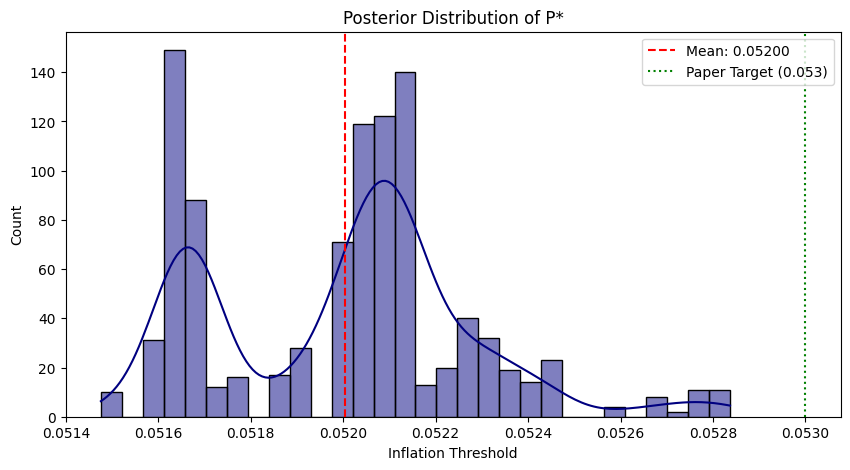

In [9]:
# FIGURE 4a (P* Distribution)
p_chain = np.array(results['P_star'])
p_mean = np.mean(p_chain)

plt.figure(figsize=(10, 5))
sns.histplot(p_chain, kde=True, color='navy', bins=30)
plt.axvline(p_mean, color='red', linestyle='--', label=f'Mean: {p_mean:.5f}')
plt.axvline(0.053, color='green', linestyle=':', label='Paper Target (0.053)')
plt.title('Posterior Distribution of P*')
plt.xlabel('Inflation Threshold')
plt.legend()
plt.show()